## Encryptix Task 3: Identify Customers that are most likely to leave the Bank (Churn Prediction)

In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Program Files\Python310\python.exe -m pip install --upgrade pip


In [59]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from lightgbm import LGBMClassifier

%matplotlib inline

In [3]:
import sys
print(sys.executable)

C:\Users\hp\anaconda3\python.exe


In [12]:
#get the dataframe
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
#check for missing values, if any remove it
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
#check for duplicates, if any only have teh first one
#df = df.duplicated(keep='first')

In [7]:
df.shape

(10000,)

In [15]:
df = pd.DataFrame(df)

df.info()

In [13]:
df.drop(columns='RowNumber', inplace=True)

In [16]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [17]:
#numeric variables
numeric_variables = [col for col in df.columns if df[col].dtype != 'object'
                    and df[col].nunique() > 11
                    and col not in 'CustomerId' ]
numeric_variables

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [18]:
#Target Variable
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [19]:
#customer leaving the bank
churn = df.loc[df['Exited']==1]

In [20]:
#customer not leaving the banck
not_churn = df.loc[df['Exited']==0]

## Categorical Variables


In [21]:
#frequency of Not churned group according to tenure
not_churn['Tenure'].value_counts().sort_values()

Tenure
0     318
10    389
6     771
9     771
4     786
3     796
1     803
5     803
8     828
2     847
7     851
Name: count, dtype: int64

In [22]:
#frequency of churned group according to tenure
churn['Tenure'].value_counts().sort_values()

Tenure
0      95
10    101
7     177
6     196
8     197
2     201
4     203
5     209
3     213
9     213
1     232
Name: count, dtype: int64

## Num of Products

In [23]:
# Frequency of not_churn group according to NumOfProducts
not_churn["NumOfProducts"].value_counts().sort_values()

NumOfProducts
3      46
1    3675
2    4242
Name: count, dtype: int64

In [24]:
# Frequency of churn group according to NumOfProducts
churn["NumOfProducts"].value_counts().sort_values()

NumOfProducts
4      60
3     220
2     348
1    1409
Name: count, dtype: int64

## Does the Customer has Credit card or Not?


In [25]:
# examining the HasCrCard of the not_churn group
not_churn["HasCrCard"].value_counts()

HasCrCard
1    5631
0    2332
Name: count, dtype: int64

In [26]:
# examining the HasCrCard of the not_churn group
not_churn["HasCrCard"].value_counts()

HasCrCard
1    5631
0    2332
Name: count, dtype: int64

## Is the customer an active member or Not?

In [27]:
# examining the IsActiveMember of the not_churn group
not_churn["IsActiveMember"].value_counts()

IsActiveMember
1    4416
0    3547
Name: count, dtype: int64

In [28]:
# examining the IsActiveMember of the churn group
churn["IsActiveMember"].value_counts()

IsActiveMember
0    1302
1     735
Name: count, dtype: int64

## What is the geographical location of the customer

In [29]:
# Frequency of not_churn group according to Geography
not_churn.Geography.value_counts().sort_values()


Geography
Germany    1695
Spain      2064
France     4204
Name: count, dtype: int64

In [30]:
# Frequency of churn group according to Geography
churn.Geography.value_counts().sort_values()

Geography
Spain      413
France     810
Germany    814
Name: count, dtype: int64

## Numerical Variables 
## 1. Credit Score

In [31]:
# Let's examine the credit score of the not_churn group
not_churn["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    7963.000000
mean      651.853196
std        95.653837
min       405.000000
5%        492.000000
25%       585.000000
50%       653.000000
75%       718.000000
90%       778.000000
95%       812.000000
99%       850.000000
max       850.000000
Name: CreditScore, dtype: float64

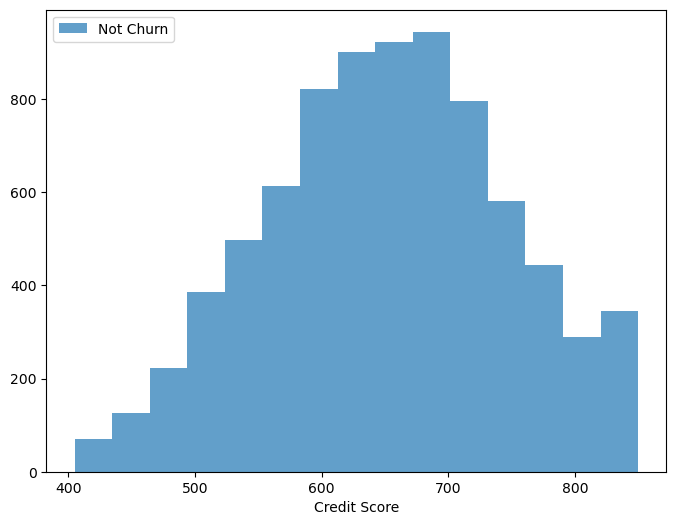

In [32]:
# Distribution of Credit Score for Not Churned custoemrs
plt.figure(figsize=(8,6))
plt.xlabel('Credit Score')
plt.hist(not_churn['CreditScore'],bins=15, alpha=0.7, label='Not Churn')
plt.legend(loc='upper left')
plt.show()

In [33]:
# examine the credit score of the churn group
churn["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    2037.000000
mean      645.351497
std       100.321503
min       350.000000
5%        479.000000
25%       578.000000
50%       646.000000
75%       716.000000
90%       776.400000
95%       812.200000
99%       850.000000
max       850.000000
Name: CreditScore, dtype: float64

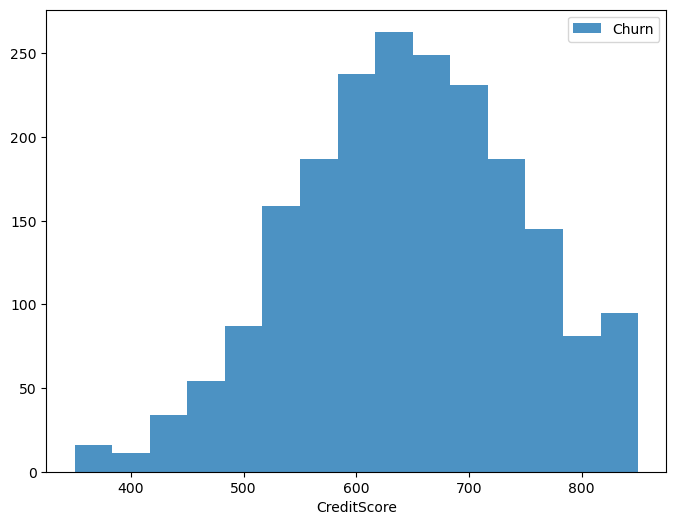

In [34]:
# distribution of the Credit Score for churn
plt.figure(figsize=(8,6))
plt.xlabel('CreditScore')
plt.hist(churn["CreditScore"],bins=15, alpha=0.8, label='Churn')
plt.legend(loc='upper right')
plt.show()

## Examining the balnce of Churn & Not Churn Group


In [35]:
# examining the Balance of the not_churn group
not_churn["Balance"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count      7963.000000
mean      72745.296779
std       62848.040701
min           0.000000
5%            0.000000
25%           0.000000
50%       92072.680000
75%      126410.280000
90%      148730.298000
95%      161592.595000
99%      183753.906200
max      221532.800000
Name: Balance, dtype: float64

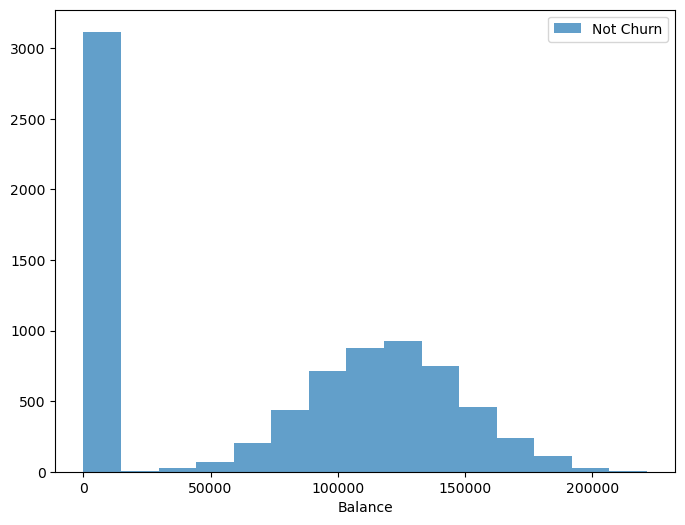

In [36]:
# distribution of the Balance for not_churn
plt.figure(figsize=(8,6))
plt.xlabel('Balance')
plt.hist(not_churn["Balance"], bins=15, alpha=0.7, label='Not Churn')
plt.legend(loc='upper right')
plt.show()

In [37]:
# examining the Balance of the churn group
churn["Balance"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count      2037.000000
mean      91108.539337
std       58360.794816
min           0.000000
5%            0.000000
25%       38340.020000
50%      109349.290000
75%      131433.330000
90%      152080.618000
95%      167698.240000
99%      197355.288400
max      250898.090000
Name: Balance, dtype: float64

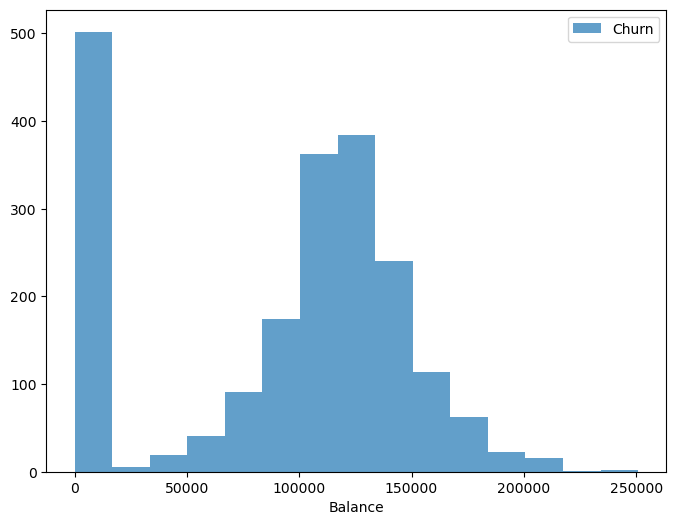

In [38]:
# distribution of the Balance for churn
plt.figure(figsize=(8,6))
plt.xlabel('Balance')
plt.hist(churn["Balance"], bins=15, alpha=0.7, label='Churn')
plt.legend(loc='upper right')
plt.show()

## Correlation Matrix

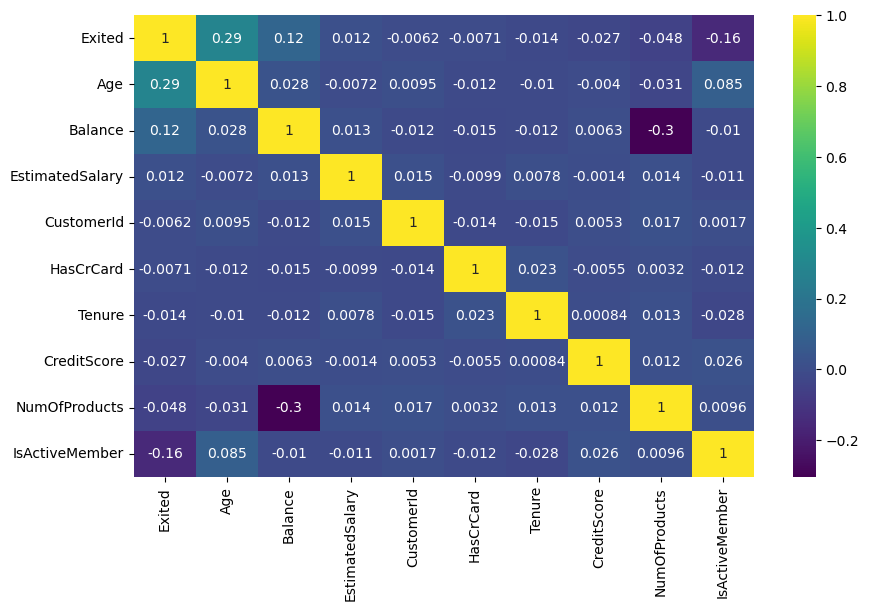

In [39]:
numeric_df = df.select_dtypes(include=[float, int])

# Number of variables for heatmap
k = 10

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Get the top k variables correlated with 'Exited'
cols = corr_matrix.nlargest(k, 'Exited')['Exited'].index

# Compute the correlation matrix for these variables
cm = numeric_df[cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, cmap='viridis')
plt.show()

# Data Preprocessing
## Outliners

In [40]:
# To determine the threshold value for outliers
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Are there any outliers in the variables
def has_outliers(dataframe, numeric_columns, plot=False):
   # variable_names = []
    for col in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, " : ", number_of_outliers, "outliers")
            #variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    #return variable_names

# There is no outlier
for var in numeric_variables:
    print(var, "has " , has_outliers(df, [var]),  "Outliers")

CreditScore has  None Outliers
Age has  None Outliers
Balance has  None Outliers
EstimatedSalary has  None Outliers


## Feature Engineering

In [41]:
# we standardize tenure with age
df["NewTenure"] = df["Tenure"]/df["Age"]
df["NewCreditsScore"] = pd.qcut(df['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df["NewAgeScore"] = pd.qcut(df['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df["NewBalanceScore"] = pd.qcut(df['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df["NewEstSalaryScore"] = pd.qcut(df['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.047619,3,6,1,6
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.024390,2,6,3,6
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.190476,1,6,5,6
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.025641,5,5,1,5
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.046512,6,6,4,4


## Scaling

In [43]:
# Removing variables that will not affect the dependent variable
df = df.drop(["CustomerId","Surname"], axis = 1)

In [44]:
# Scale features using statistics that are robust to outliers.
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.01)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)

        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

In [45]:
new_cols_ohe = ["Gender_Male","Geography_Germany","Geography_Spain"]
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) <= 10]
cols_need_scale = [col for col in df.columns if col not in new_cols_ohe
                   and col not in "Exited"
                   and col not in like_num]

for col in cols_need_scale:
    df[col] = robust_scaler(df[col])

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Gender_Male,Geography_Germany,Geography_Spain
0,-0.246,0.417,-0.75,-0.761,1,1,1,0.012,1,-0.217,3,6,1,6,False,False,False
1,-0.328,0.333,-1.00,-0.105,1,0,1,0.126,0,-0.279,2,6,3,6,False,False,True
2,-1.119,0.417,0.75,0.489,3,1,0,0.140,1,0.164,1,6,5,6,False,False,False
3,0.351,0.167,-1.00,-0.761,2,0,0,-0.065,0,-0.276,5,5,1,5,False,False,False
4,1.478,0.500,-0.75,0.222,1,1,1,-0.215,0,-0.220,6,6,4,4,False,False,True


## Modeling

In [62]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

X = df.drop("Exited",axis=1)
y = df["Exited"]
# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12345)
# Models for Classification
models = [('LR', LogisticRegression(random_state=123456)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=123456)),
          ('RF', RandomForestClassifier(random_state=123456)),
          ('SVR', SVC(gamma='auto',random_state=123456)),
          ('GB', GradientBoostingClassifier(random_state = 12345)),
          ("LightGBM", LGBMClassifier(random_state=123456))]

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456,shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.825600 (0.008499)
KNN: 0.820900 (0.009648)
CART: 0.790600 (0.011047)
RF: 0.861900 (0.008324)
SVR: 0.845200 (0.008195)
GB: 0.865000 (0.008426)
[LightGBM] [Info] Number of positive: 1832, number of negative: 7168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203556 -> initscore=-1.364218
[LightGBM] [Info] Start training from score -1.364218
[LightGBM] [Info] Number of positive: 1827, number of negative: 7173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data

In [63]:
# GB Confusion Matrix
model_GB = GradientBoostingClassifier(random_state=12345)
model_GB.fit(X_train, y_train)
y_pred = model_GB.predict(X_test)
conf_mat = confusion_matrix(y_pred,y_test)
conf_mat

array([[1520,  230],
       [  53,  197]], dtype=int64)

In [64]:
print("True Positive : ", conf_mat[1, 1])
print("True Negative : ", conf_mat[0, 0])
print("False Positive: ", conf_mat[0, 1])
print("False Negative: ", conf_mat[1, 0])

True Positive :  197
True Negative :  1520
False Positive:  230
False Negative:  53


In [65]:
# Classification Report for XGB Model
print(classification_report(model_GB.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.97      0.87      0.91      1750
           1       0.46      0.79      0.58       250

    accuracy                           0.86      2000
   macro avg       0.71      0.83      0.75      2000
weighted avg       0.90      0.86      0.87      2000



In [66]:
# Auc Roc Curve
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

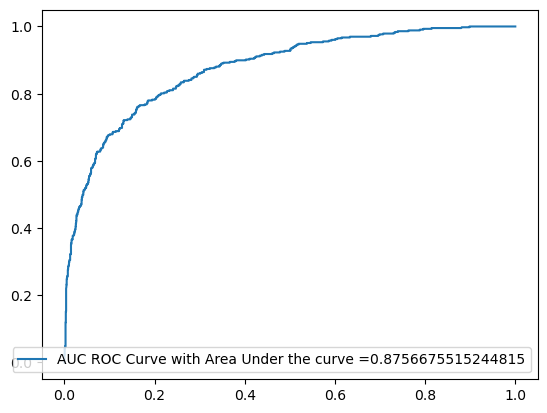

In [56]:
generate_auc_roc_curve(model_GB, X_test)

## Model Tuning

In [67]:
# LightGBM: 
lgb_model = LGBMClassifier()
# Model Tuning
lgbm_params = {'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 500}

lgbm_tuned = LGBMClassifier(**lgbm_params).fit(X, y)

[LightGBM] [Info] Number of positive: 2037, number of negative: 7963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1137
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203700 -> initscore=-1.363328
[LightGBM] [Info] Start training from score -1.363328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [68]:
#Let's choose the highest 4 models
# GBM
gbm_model = GradientBoostingClassifier()
# Model Tuning
gbm_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
gbm_tuned = GradientBoostingClassifier(**gbm_params).fit(X,y)

In [70]:
# evaluate each model in turn
models = [("LightGBM", lgbm_tuned),
          ("GB",gbm_tuned)]
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456,shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

[LightGBM] [Info] Number of positive: 1833, number of negative: 7167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203667 -> initscore=-1.363533
[LightGBM] [Info] Start training from score -1.363533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Info] Number of positive: 1610, number of negative: 6390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1138
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201250 -> initscore=-1.378500
[LightGBM] [Info] Start training from score -1.378500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

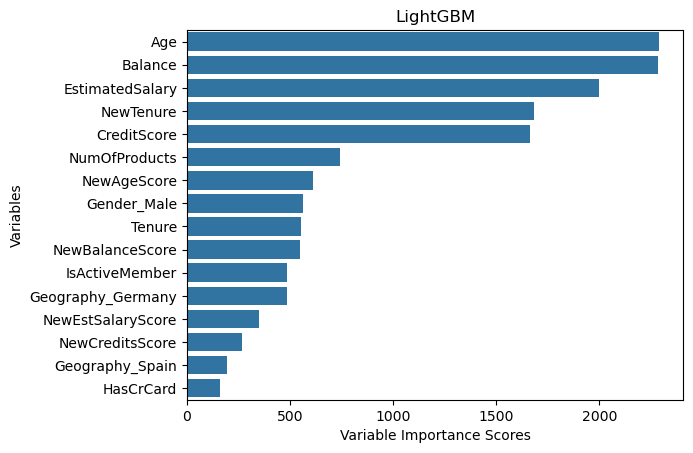

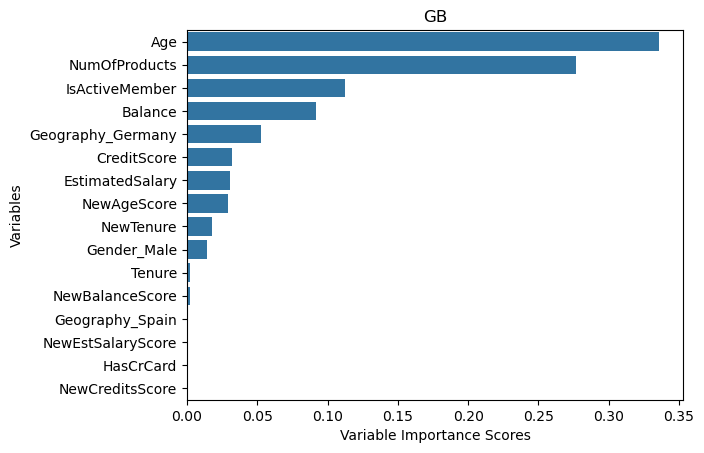

In [72]:
for name, model in models:
        base = model.fit(X_train,y_train)
        y_pred = base.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        feature_imp = pd.Series(base.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Variable Importance Scores')
        plt.ylabel('Variables')
        plt.title(name)
        plt.show()